In [ ]:
! pip install python_splitter
import python_splitter
python_splitter.split_from_folder("/content/drive/MyDrive/faces", train=0.8, test=0.1, val=0.1)

✅Checking SOURCE directory...
0.8 0.1 0.1
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import Model
image_size = 224
batch_size = 16 
num_classes = 8

base_model = ResNet152V2(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = True

x = layers.Flatten()(base_model.output)
x = layers.Dropout(0.5)(x)
prediction = layers.Dense(num_classes, activation='softmax')(x)

res_model = Model(inputs=base_model.input, outputs=prediction)

res_model.summary()

res_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory(
    '/content/Train_Test_Folder/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    '/content/Train_Test_Folder/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

def lr_schedule(epoch):
    if epoch < 5:
        return 1e-4*(epoch + 1) 
    else:
        return 1e-4*tf.math.exp(0.1*(5-epoch)) 
    
learning_rate_scheduler = LearningRateScheduler(lr_schedule)

r = res_model.fit(train_set, validation_data=test_set,epochs=20,steps_per_epoch=len(train_set),validation_steps=len(test_set),callbacks=[learning_rate_scheduler],
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

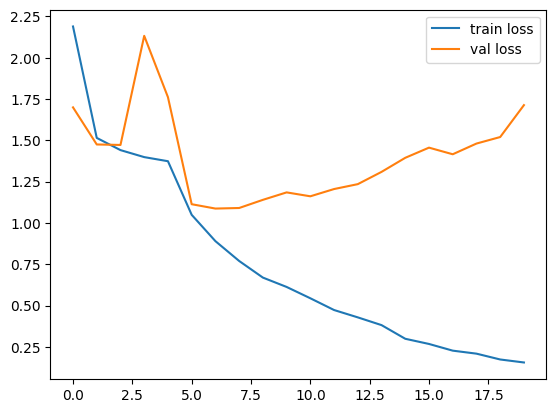

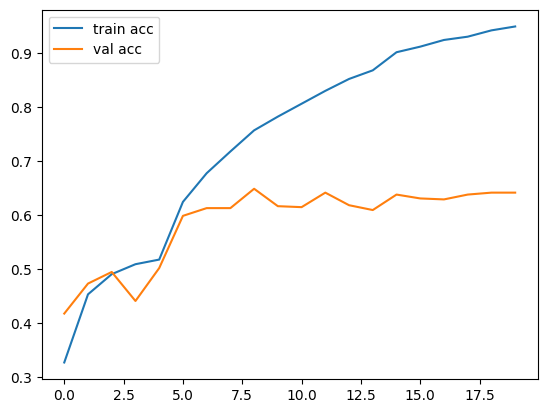

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
res_model.save('face_resnet.h5')